In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import os
import fastmri
from fastmri.data import transforms as T

/home/yusuf/miniconda3/envs/fastmri_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
upre_path = "/home/yusuf/Desktop/projects/repos/fastMRI/fastmri_examples/unet/inference/reconstructions"
varpre_path = "/home/yusuf/Desktop/projects/repos/fastMRI/fastmri_examples/varnet/inference/reconstructions"
varrecs_path = "/home/yusuf/Desktop/projects/repos/fastMRI/fastmri_examples/varnet/varnet/varnet_demo/reconstructions"
urecs_path = "/home/yusuf/Desktop/projects/repos/fastMRI/fastmri_examples/unet/unet/unet_demo/reconstructions"
test_path = "/media/yusuf/768d73b3-d184-48a4-a0f5-8589d0859811/home/data/multicoil_test"
test_full_path = "/home/yusuf/Desktop/projects/data/multicoil_test_full"

In [4]:
def image_read(path,data_idx,slice_idx,kspace=False):
    data = sorted(os.listdir(path))
    file_name = f'{path}/{data[data_idx]}'
    hf = h5py.File(file_name)

    if kspace:
        volume_kspace = hf['kspace'][()]
        slice_kspace = volume_kspace[slice_idx]
        slice_kspace2 = T.to_tensor(slice_kspace)
        slice_image = fastmri.ifft2c(slice_kspace2)
        slice_image_abs = fastmri.complex_abs(slice_image) 
        slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

        return slice_image_rss
    
    try:
        volume_kspace = hf['reconstruction'][()][slice_idx]
    except:
        volume_kspace = hf['reconstruction_rss'][()][slice_idx]
    
    return volume_kspace

In [5]:
data = sorted(os.listdir(test_path))
file_name = f'{test_path}/{data[0]}'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'AXFLAIR', 'num_low_frequency': 26, 'patient_id': 'f426088638b86dc2507548fdb24e3df8e35591f412533d3a337b3790fa330d33'}


In [6]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [7]:
def compute_metrics(path_recon, path_ground_truth):
    ssim_scores = []
    psnr_scores = []

    # Get the list of files
    num_files = len(sorted(os.listdir(path_recon)))

    # Iterate through all files
    for data_idx in range(num_files):
        # Read ground truth and reconstructed volumes
        file_recon = sorted(os.listdir(path_recon))[data_idx]
        file_gt = sorted(os.listdir(path_ground_truth))[data_idx]
        
        with h5py.File(f"{path_recon}/{file_recon}", 'r') as recon_hf, \
             h5py.File(f"{path_ground_truth}/{file_gt}", 'r') as gt_hf:
            
            # Get number of slices
            num_slices = recon_hf['reconstruction'].shape[0]
            
            for slice_idx in range(num_slices):
                # Read the reconstructed and ground truth slices
                recon_slice = image_read(path_recon, data_idx, slice_idx)
                gt_slice = image_read(path_ground_truth, data_idx, slice_idx)

                if recon_slice.ndim == 3 and recon_slice.shape[0] == 1:
                    recon_slice = np.squeeze(recon_slice, axis=0)
                if gt_slice.ndim == 3 and gt_slice.shape[0] == 1:
                    gt_slice = np.squeeze(gt_slice, axis=0)

                # Normalize slices
                #gt_slice = gt_slice / np.max(gt_slice)  # Normalize GT to [0, 1]
                #recon_slice = recon_slice / np.max(gt_slice)  # Normalize to GT's range
                drange=np.max(gt_slice)-np.min(gt_slice)


                # Compute SSIM and PSNR
                ssim_score = ssim(recon_slice, gt_slice, data_range=drange)
                psnr_score = psnr(recon_slice, gt_slice, data_range=drange)

                # Append scores
                ssim_scores.append(ssim_score)
                psnr_scores.append(psnr_score)

    # Aggregate results
    mean_ssim = np.mean(ssim_scores)
    std_ssim = np.std(ssim_scores)
    mean_psnr = np.mean(psnr_scores)
    std_psnr = np.std(psnr_scores)

    # Print results
    print(f"SSIM: Mean = {mean_ssim:.4f}, Std = {std_ssim:.4f}")
    print(f"PSNR: Mean = {mean_psnr:.4f}, Std = {std_psnr:.4f}")



In [35]:
upre_res=compute_metrics(upre_path, test_full_path)
urecs_res=compute_metrics(urecs_path, test_full_path)
varpre_res=compute_metrics(varpre_path, test_full_path)
varrec_res=compute_metrics(varrecs_path, test_full_path)


SSIM: Mean = 0.8826, Std = 0.1186
PSNR: Mean = 33.9875, Std = 3.3245
SSIM: Mean = 0.2853, Std = 0.1162
PSNR: Mean = 16.0716, Std = 1.9711
SSIM: Mean = 0.9032, Std = 0.1176
PSNR: Mean = 36.7000, Std = 3.6954
SSIM: Mean = 0.6509, Std = 0.1118
PSNR: Mean = 24.5444, Std = 2.8684
None None None None


In [9]:
yopath = varrecs_path = "/home/yusuf/Desktop/projects/repos/fastMRI/fastmri_examples/varnet/varnet/reconstructions"

eski = compute_metrics(yopath, test_full_path)
yeni = compute_metrics(varrecs_path, test_full_path)

SSIM: Mean = 0.6509, Std = 0.1118
PSNR: Mean = 24.5444, Std = 2.8684
SSIM: Mean = 0.6509, Std = 0.1118
PSNR: Mean = 24.5444, Std = 2.8684


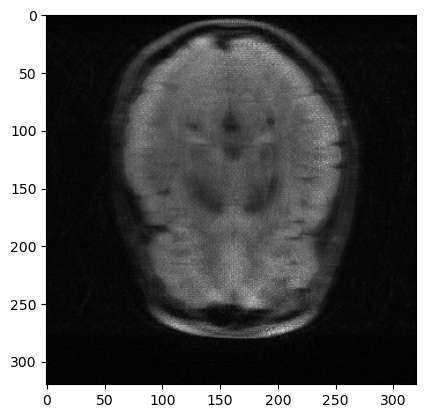

In [41]:
yo = image_read(varrecs_path,0,0)
plt.imshow(yo,cmap="gray")

In [9]:
varrecs_img = image_read(varrecs_path,0,0)
urecs_img = image_read(urecs_path,0,0)
varpre_img = image_read(varpre_path,0,0)
upre_img = image_read(upre_path,0,0)[0]
gt_img = image_read(test_full_path,0,0)

In [93]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [105]:
img_range=np.max(gt_img)-np.min(gt_img)

In [109]:
print(psnr(gt_img,varpre_img,data_range=img_range))
print(ssim(gt_img,varpre_img,data_range=img_range))

35.86272588181032


0.9143787659364635

In [110]:
print(psnr(gt_img,upre_img,data_range=range))
print(ssim(gt_img,upre_img,data_range=range))

32.76749667542271
0.8732795639861178


In [111]:
print(psnr(gt_img,varrecs_img,data_range=range))
print(ssim(gt_img,varrecs_img,data_range=range))

24.51565613792927
0.6239665737383647


In [112]:
print(psnr(gt_img,urecs_img,data_range=range))
print(ssim(gt_img,urecs_img,data_range=range))

12.608305878064233
0.1316401691037472


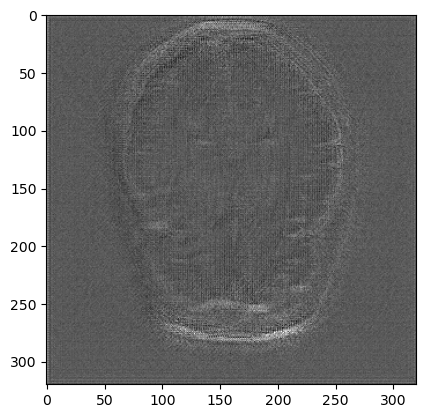

In [90]:
yo = image_read(urecs_path,0,0)

plt.imshow(yo,cmap='gray')

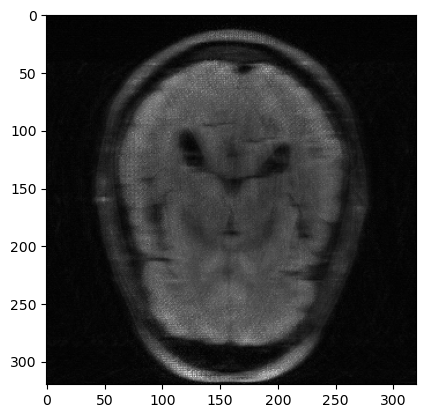

In [27]:
var_img = image_read(var_recs_path,0)[0]
gt_img = image_read(var_recs_path,0)[0]


plt.imshow(yo,cmap='gray')

In [6]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['reconstruction']
Attrs: {}


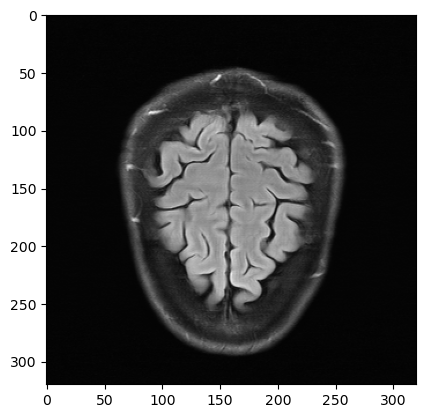

In [10]:
plt.imshow(slice_kspace,cmap='gray')

In [ ]:
def test_vis(path, idx):
    os.path

In [12]:
path = "/home/yusuf/Desktop/projects/data/multicoil_test_full"
data = os.listdir(path)
file_name = f'{path}/{data[0]}'
hf = h5py.File(file_name)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.00038573158745517424, 'norm': 0.08619659997591468, 'patient_id': '6001880'}


float32
(16, 320, 320)


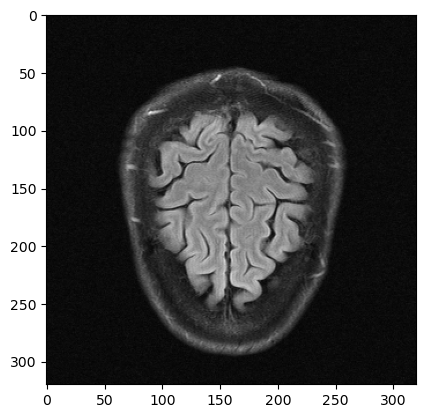

In [14]:
slice_index=10
volume_kspace = hf['reconstruction_rss'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)
slice_kspace = volume_kspace[slice_index]

plt.imshow(slice_kspace,cmap='gray')

In [97]:
import fastmri
from fastmri.data import transforms as T

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image) 

ValueError: Tensor does not have separate complex dim.

In [77]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 768, 396)


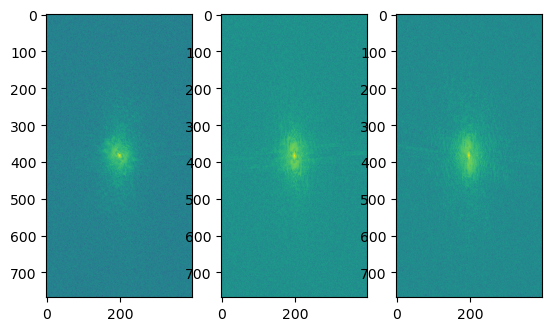

In [80]:
slice_kspace = volume_kspace[6] # Choosing the *16-th slice of this volume
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 1, 2])  # This shows coils 0, *1 and *2

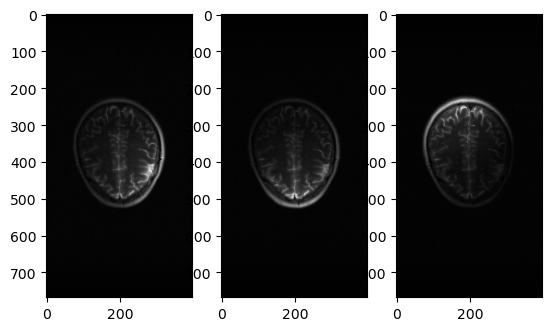

In [81]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

show_coils(slice_image_abs, [0, 1, 2], cmap='gray')

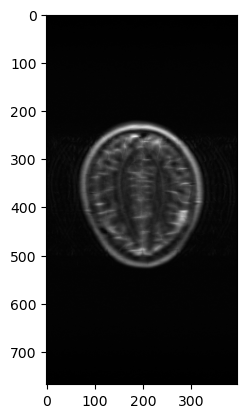

In [59]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

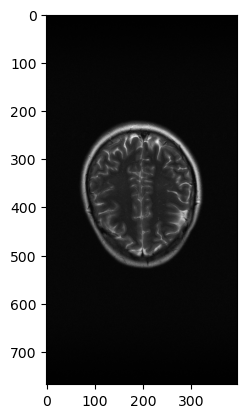

In [82]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [15]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)